In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 1. MNIST 데이터셋 다운로드

In [12]:
transform = transforms.ToTensor() # 이미지->Tensor 변환 ([0,255] → [0,1](정규화), shape: (1, 28, 28))

train_dataset = datasets.MNIST(
    root='./data', # 상대 경로 (현재 디렉토리 기준)에 data 폴더 생성 및 데이터 저장
    train=True, # MNIST에서 학습용 데이터 가져오기
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False, # MNIST에서 테스트용 데이터 가져오기
    transform=transform,
    download=True
)

In [13]:
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


대충 하나 출력해보기

image shape: torch.Size([1, 28, 28])
label: 7


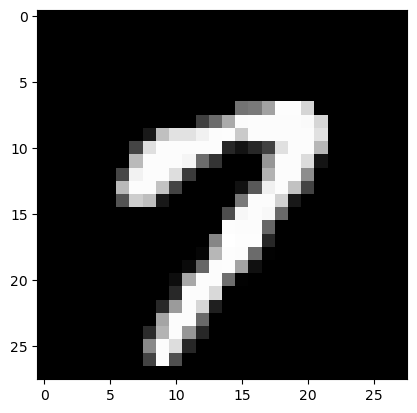

In [14]:
import matplotlib.pyplot as plt

image, label = train_dataset[15]

print("image shape:", image.shape)
print("label:", label)

plt.imshow(image.squeeze(), cmap='gray') # 몰라도 됩니다
plt.show() # 몰라도 됩니다

# 2. DataLoader로 배치별로 나누기

In [15]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False
)

print("Number of training batches:", len(train_loader))
print("Number of test batches:", len(test_loader))

Number of training batches: 938
Number of test batches: 157


In [16]:
for images, labels in train_loader:
    print("Batch image shape:", images.shape)
    print("Batch label shape:", labels.shape)
    break

Batch image shape: torch.Size([64, 1, 28, 28])
Batch label shape: torch.Size([64])


# 3. MLP 모델 구조화

In [17]:
# MLP 모델 정의 (nn.Sequential 미사용)

class MNISTMLP_noSequential(nn.Module):
    def __init__(self):
        super().__init__()

        # Layer 정의
        self.fc1 = nn.Linear(28 * 28, 256) # 첫 번째 은닉층, 784 → 256
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(256, 128) # 두 번째 은닉층, 256 → 128
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(128, 10)  # 출력층, softmax는 이미 nn.CrossEntropyLoss()에 포함되어 있음

    def forward(self, x):
        # x: (batch, 1, 28, 28) → (batch, 784) 변환(flatten)
        x = x.view(x.size(0), -1)

        # Layer를 순서대로 적용
        x = self.fc1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.relu2(x)

        x = self.fc3(x)
        return x

nn.Sequential을 안 쓰면 코드가 과하게 길어지고 가독성이 떨어진다!

In [18]:
# MLP 모델 정의 (nn.Sequential 사용)

class MNISTMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.net(x)
        return out

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [20]:
model = MNISTMLP().to(device)

criterion = nn.CrossEntropyLoss()      # 분류 국룰
optimizer = optim.SGD(model.parameters(), lr=0.1)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# 한 epoch 학습 함수

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train() # 모델을 학습 모드로 설정: Dropout, BatchNorm 등 학습 모드로 설정(하지만 여기서는 Dropout, BatchNorm 안 써서 영향 없음)
    total_loss = 0.0 # 누적 손실
    correct = 0 # 맞춘 개수
    total = 0 # 전체 개수

    for images, labels in loader:
        images = images.to(device) # 입력 이미지 텐서를 device(GPU 또는 CPU)로 이동
        labels = labels.to(device) # 레이블 텐서를 device(GPU 또는 CPU)로 이동

        # 1. gradient 초기화
        optimizer.zero_grad()

        # 2. forward
        outputs = model(images)          # shape: (batch, 10)

        # 3. loss 계산
        loss = criterion(outputs, labels)

        # 4. backward
        loss.backward()

        # 5. update
        optimizer.step()

        # 6. 통계
        total_loss += loss.item() * images.size(0) # 배치 손실에 배치 크기 곱해서 누적
        _, predicted = outputs.max(dim = 1)    # 1번째 dimension에서 최대값의 값과 인덱스 추출(그러나 값은 사용X)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = total_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [22]:
# 한 epoch 평가 함수

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval() # 모델을 평가 모드로 설정
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        # 1. forward
        outputs = model(images)

        # 2. loss 계산
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [23]:
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(
        f"Epoch [{epoch}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
        f"| Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}"
    )

Epoch [1/5] Train Loss: 0.4842, Train Acc: 0.8598 | Test Loss: 0.2216, Test Acc: 0.9322
Epoch [2/5] Train Loss: 0.1827, Train Acc: 0.9463 | Test Loss: 0.1472, Test Acc: 0.9546
Epoch [3/5] Train Loss: 0.1221, Train Acc: 0.9643 | Test Loss: 0.1114, Test Acc: 0.9654
Epoch [4/5] Train Loss: 0.0903, Train Acc: 0.9731 | Test Loss: 0.0965, Test Acc: 0.9695
Epoch [5/5] Train Loss: 0.0714, Train Acc: 0.9788 | Test Loss: 0.0864, Test Acc: 0.9722


In [24]:
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

Total parameters: 235146
